In [1]:
!pip install category_encoders

     |████████████████████████████████| 81kB 5.5MB/s 


In [2]:
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import category_encoders as ce

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
cd = pd.read_csv('https://raw.githubusercontent.com/Varadad/Personalize_Pricing/main/Datasets/customer_data.csv')
ocd = pd.read_csv('https://raw.githubusercontent.com/Varadad/Personalize_Pricing/main/Datasets/order_customer_data.csv') #most important file
oid = pd.read_csv('https://raw.githubusercontent.com/Varadad/Personalize_Pricing/main/Datasets/order_item_data.csv')
opd = pd.read_csv('https://raw.githubusercontent.com/Varadad/Personalize_Pricing/main/Datasets/order_payment_data.csv')
pdd = pd.read_csv('https://raw.githubusercontent.com/Varadad/Personalize_Pricing/main/Datasets/product_data.csv')
pnd = pd.read_csv('https://raw.githubusercontent.com/Varadad/Personalize_Pricing/main/Datasets/product_name_data.csv')

In [4]:
cd_oid = cd.join(oid,how = 'left')
cd_oid_opd = cd_oid.merge(opd, on = 'order_id', how = 'left')
cd_oid_opd_pdd = cd_oid_opd.merge(pdd, on = 'product_id', how = 'left')
cd_oid_opd_pdd_pnd = cd_oid_opd_pdd.merge(pnd, on = 'product_category_name', how ='left')

In [5]:
df = cd_oid_opd_pdd_pnd[['customer_id', 'customer_unique_id','order_id', 'seller_id','product_id','product_category_name_english', 'customer_city', 'customer_state', 'price', 'freight_value','payment_value','product_weight_g', 'product_length_cm','product_height_cm','product_width_cm']]
df

,customer_id,customer_unique_id,order_id,seller_id,product_id,product_category_name_english,customer_city,customer_state,price,freight_value,payment_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,franca,SP,58.90,13.29,72.19,650.0,28.0,9.0,14.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,e5f2d52b802189ee658865ca93d83a8f,pet_shop,sao bernardo do campo,SP,239.90,19.93,259.83,30000.0,50.0,30.0,40.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,sao paulo,SP,199.00,17.87,216.87,3050.0,33.0,13.0,33.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,7634da152a4610f1595efa32f14722fc,perfumery,mogi das cruzes,SP,12.99,12.79,25.78,200.0,16.0,10.0,15.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,ac6c3623068f30de03045865e4e10089,garden_tools,campinas,SP,199.90,18.14,218.04,3750.0,35.0,40.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103801,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,e18cc7fc5eb938dd26feb68acbf88642,dc317f341ab0e22f39acbd9dbf9b4a1f,28ce57ecf4afba85e6020ec0209cada9,cool_stuff,sao paulo,SP,249.90,69.21,319.11,5650.0,73.0,73.0,20.0
103802,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,e18cd51191ffbe2bca934d1d13805164,955fee9216a65b617aa5c0531780ce60,aca2eb7d00ea1a7b8ebd4e68314663af,furniture_decor,taboao da serra,SP,75.00,20.02,190.04,2600.0,50.0,10.0,30.0
103803,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,e18cd51191ffbe2bca934d1d13805164,955fee9216a65b617aa5c0531780ce60,aca2eb7d00ea1a7b8ebd4e68314663af,furniture_decor,fortaleza,CE,75.00,20.02,190.04,2600.0,50.0,10.0,30.0
103804,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,e18d0e097ef9cdd7894ed1b82a2b7479,c42fd8e4d47dfb18ce5222f2dd7752f9,41171e11f920c47deb1809edda2bf09d,furniture_decor,canoas,RS,26.00,10.96,36.96,200.0,16.0,16.0,16.0


In [6]:
#considering customer_id for training which will over fit the data giving high variance/overfitting the model
X1 = df[['product_id','product_category_name_english','customer_id', 'customer_unique_id', 'seller_id','customer_city', 'customer_state','price','freight_value', 'payment_value','product_weight_g', 'product_length_cm','product_height_cm','product_width_cm']]
X1 = X1.dropna()
X1

,product_id,product_category_name_english,customer_id,customer_unique_id,seller_id,customer_city,customer_state,price,freight_value,payment_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,48436dade18ac8b2bce089ec2a041202,franca,SP,58.90,13.29,72.19,650.0,28.0,9.0,14.0
1,e5f2d52b802189ee658865ca93d83a8f,pet_shop,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,dd7ddc04e1b6c2c614352b383efe2d36,sao bernardo do campo,SP,239.90,19.93,259.83,30000.0,50.0,30.0,40.0
2,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,5b51032eddd242adc84c38acab88f23d,sao paulo,SP,199.00,17.87,216.87,3050.0,33.0,13.0,33.0
3,7634da152a4610f1595efa32f14722fc,perfumery,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,9d7a1d34a5052409006425275ba1c2b4,mogi das cruzes,SP,12.99,12.79,25.78,200.0,16.0,10.0,15.0
4,ac6c3623068f30de03045865e4e10089,garden_tools,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,df560393f3a51e74553ab94004ba5c87,campinas,SP,199.90,18.14,218.04,3750.0,35.0,40.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103801,28ce57ecf4afba85e6020ec0209cada9,cool_stuff,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,dc317f341ab0e22f39acbd9dbf9b4a1f,sao paulo,SP,249.90,69.21,319.11,5650.0,73.0,73.0,20.0
103802,aca2eb7d00ea1a7b8ebd4e68314663af,furniture_decor,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,955fee9216a65b617aa5c0531780ce60,taboao da serra,SP,75.00,20.02,190.04,2600.0,50.0,10.0,30.0
103803,aca2eb7d00ea1a7b8ebd4e68314663af,furniture_decor,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,955fee9216a65b617aa5c0531780ce60,fortaleza,CE,75.00,20.02,190.04,2600.0,50.0,10.0,30.0
103804,41171e11f920c47deb1809edda2bf09d,furniture_decor,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,c42fd8e4d47dfb18ce5222f2dd7752f9,canoas,RS,26.00,10.96,36.96,200.0,16.0,16.0,16.0


In [7]:
# X1.groupby('customer_state').count().reset_index()

In [8]:
#Encoding City
city1 = X1.groupby('customer_city').sum().reset_index()
city1 = city1[['customer_city', 'payment_value']]
city1.columns = ['customer_city', 'payment_city']

In [9]:
city1_encoded = X1.merge(city1, on = 'customer_city', how ='left')
encoder=ce.TargetEncoder(cols='customer_city') 
city1_encoded['customer_city1_encoded'] = encoder.fit_transform(city1_encoded['customer_city'],city1_encoded['payment_city'])

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [10]:
#Encoding state
state1 = X1.groupby('customer_state').sum().reset_index()
state1 = state1[['customer_state', 'payment_value']]
state1.columns = ['customer_state', 'payment_state']

In [11]:
state1_encoded = city1_encoded.merge(state1, on = 'customer_state', how ='left')
encoder=ce.TargetEncoder(cols='customer_state') 
state1_encoded['customer_state1_encoded'] = encoder.fit_transform(state1_encoded['customer_state'],state1_encoded['payment_state'])

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [12]:
#Encoding Product Category
category1 = X1.groupby('product_category_name_english').sum().reset_index()
category1 = category1[['product_category_name_english', 'payment_value']]
category1.columns = ['product_category_name_english', 'payment_category']

In [13]:
category1_encoded = state1_encoded.merge(category1, on = 'product_category_name_english', how ='left')
encoder=ce.TargetEncoder(cols='product_category_name_english') 
category1_encoded['customer_category1_encoded'] = encoder.fit_transform(category1_encoded['product_category_name_english'],category1_encoded['payment_category'])

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [14]:
#Encoding customer
customer1 = category1_encoded.groupby('customer_id').sum().reset_index()
customer1 = customer1[['customer_id', 'payment_value']]
customer1.columns = ['customer_id', 'customer_payment']

In [15]:
customer1_encoded = category1_encoded.merge(customer1, on = 'customer_id', how ='left')
encoder=ce.TargetEncoder(cols='customer_id') 
customer1_encoded['customer_customer1_encoded'] = encoder.fit_transform(customer1_encoded['customer_id'],customer1_encoded['customer_payment'])

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [16]:
#Encoding Product
product1 = customer1_encoded.groupby('product_id').sum().reset_index()
product1 = product1[['product_id', 'payment_value']]
product1.columns = ['product_id', 'product_price_encoded']

In [17]:
product1_encoded = customer1_encoded.merge(product1, on = 'product_id', how ='left')
encoder=ce.TargetEncoder(cols='product_id') 
product1_encoded['customer_product1_encoded'] = encoder.fit_transform(product1_encoded['product_id'], product1_encoded['product_price_encoded'])

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [18]:
#Encoding Unique Customer
unique_cust1 = product1_encoded.groupby('customer_unique_id').sum().reset_index()
unique_cust1 = unique_cust1[['customer_unique_id', 'price']]
unique_cust1.columns = ['customer_unique_id', 'unique_customer_payment']

In [19]:
unique_cust1_encoded = product1_encoded.merge(unique_cust1, on = 'customer_unique_id', how = 'left')
encoder=ce.TargetEncoder(cols='customer_unique_id') 
unique_cust1_encoded['customer_uniquecust1_encoded'] = encoder.fit_transform(unique_cust1_encoded['customer_unique_id'], unique_cust1_encoded['unique_customer_payment'])

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [20]:
#Encoding Seller
seller1 = unique_cust1_encoded.groupby('seller_id').sum().reset_index()
seller1 = seller1[['seller_id', 'payment_value']]
seller1.columns = ['seller_id', 'seller_payment']

In [21]:
seller1_encoded = unique_cust1_encoded.merge(seller1, on = 'seller_id', how = 'left')
encoder=ce.TargetEncoder(cols='seller_id') 
seller1_encoded['seller1_encoded'] = encoder.fit_transform(seller1_encoded['seller_id'], seller1_encoded['seller_payment'])

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [22]:
#parameters to train the NN
X = seller1_encoded[['customer_city1_encoded','customer_state1_encoded','customer_product1_encoded', 'payment_value', 'seller1_encoded', 'customer_uniquecust1_encoded', 'freight_value','product_weight_g','product_length_cm','product_height_cm','product_width_cm']].dropna()
X

,customer_city1_encoded,customer_state1_encoded,customer_product1_encoded,payment_value,seller1_encoded,customer_uniquecust1_encoded,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,35241.78,7.458064e+06,808.317273,72.19,16419.110000,152.021246,13.29,650.0,28.0,9.0,14.0
1,163895.33,7.458064e+06,4933.281526,259.83,11574.910000,152.021246,19.93,30000.0,50.0,30.0,40.0
2,2745623.55,7.458064e+06,1311.997499,216.87,5936.972236,152.021246,17.87,3050.0,33.0,13.0,33.0
3,76508.38,7.458064e+06,1364.457126,25.78,2556.247077,152.021246,12.79,200.0,16.0,10.0,15.0
4,274683.09,7.458064e+06,2306.244202,218.04,3455.690000,152.021246,18.14,3750.0,35.0,40.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...
102277,2745623.55,7.458064e+06,1443.156992,319.11,21204.410000,152.021246,69.21,5650.0,73.0,73.0,20.0
102278,49219.94,7.458064e+06,57242.680000,190.04,202191.560000,152.021246,20.02,2600.0,50.0,10.0,30.0
102279,113254.85,2.358325e+05,57242.680000,190.04,202191.560000,152.021246,20.02,2600.0,50.0,10.0,30.0
102280,35183.46,9.625712e+05,1383.830178,36.96,1138.254496,152.021246,10.96,200.0,16.0,16.0,16.0


In [23]:
#label
y = category1_encoded[['price']].dropna()
y

,price
0,58.90
1,239.90
2,199.00
3,12.99
4,199.90
...,...
102277,249.90
102278,75.00
102279,75.00
102280,26.00


In [24]:
#Splitting training and testing data
X_train, X_test, y_train, y_test = X.iloc[0:80000, :], X.iloc[80000:, :], y.iloc[0:80000], y.iloc[80000:] 

In [25]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

In [26]:
#importing Tensorflow 
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [27]:
#defining the model and adding neural network layers
from keras import regularizers
model = keras.Sequential(([
    layers.Dense(55, activation='relu', input_shape=[11], kernel_regularizer=regularizers.l2(0.01)),
    # layers.Dropout(0.30, seed=None),
    layers.Dense(55, activation='swish'),
    layers.Dense(55, activation='relu'),
    layers.Dense(55, activation='relu'),
    layers.Dense(55, activation='relu'),
    layers.Dense(1)
]))


In [28]:
#compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics=['mae'])

In [29]:
#Training the model
history = model.fit(X_train_norm, y_train, epochs = 500, validation_split = 0.2, use_multiprocessing = True)

Epoch 1/500
2000/2000 [==============================] - 7s 3ms/step - loss: 24518.8049 - mae: 78.8671 - val_loss: 12806.7051 - val_mae: 55.8797
Epoch 2/500
2000/2000 [==============================] - 5s 2ms/step - loss: 12018.1277 - mae: 54.2783 - val_loss: 13110.4072 - val_mae: 58.2421
Epoch 3/500
2000/2000 [==============================] - 5s 2ms/step - loss: 9642.3507 - mae: 50.4487 - val_loss: 10789.5938 - val_mae: 52.0810
Epoch 4/500
2000/2000 [==============================] - 5s 2ms/step - loss: 9566.6392 - mae: 51.5050 - val_loss: 10002.1846 - val_mae: 48.3433
Epoch 5/500
2000/2000 [==============================] - 5s 2ms/step - loss: 8625.4644 - mae: 49.0889 - val_loss: 10185.7578 - val_mae: 52.7243
Epoch 6/500
2000/2000 [==============================] - 5s 2ms/step - loss: 8347.0379 - mae: 48.1979 - val_loss: 9191.3828 - val_mae: 49.7188
Epoch 7/500
2000/2000 [==============================] - 5s 2ms/step - loss: 8457.5605 - mae: 48.7810 - val_loss: 9518.9707 - val_mae: 

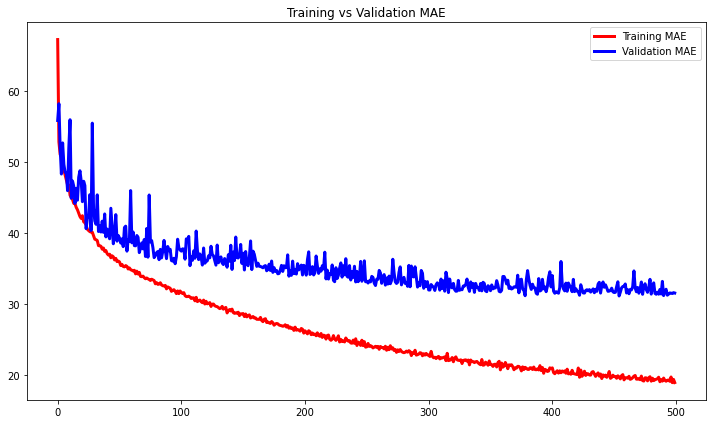

In [30]:
import matplotlib.pyplot as plt
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(figsize=(10,6))
num_epochs = model_history.shape[0]
ax.plot(np.arange(0, num_epochs), model_history["mae"], 
        label="Training MAE", lw=3, color='r')
ax.plot(np.arange(0, num_epochs), model_history["val_mae"], 
        label="Validation MAE", lw=3, color='b')
ax.legend()
plt.title('Training vs Validation MAE')
plt.tight_layout()
plt.savefig("train vs validation.png")
plt.show()

In [31]:
y_pred = model.predict(X_test_norm)

In [32]:
# colors = {'y_test': 'pink', 'y_pred': 'blue'}
y_test = y_test.to_numpy()

In [33]:
from sklearn.metrics import r2_score, mean_absolute_error
score = r2_score(y_test, y_pred)
mean_error = mean_absolute_error(y_test, y_pred)
score, mean_error


(0.7540969616287629, 31.665867942171992)

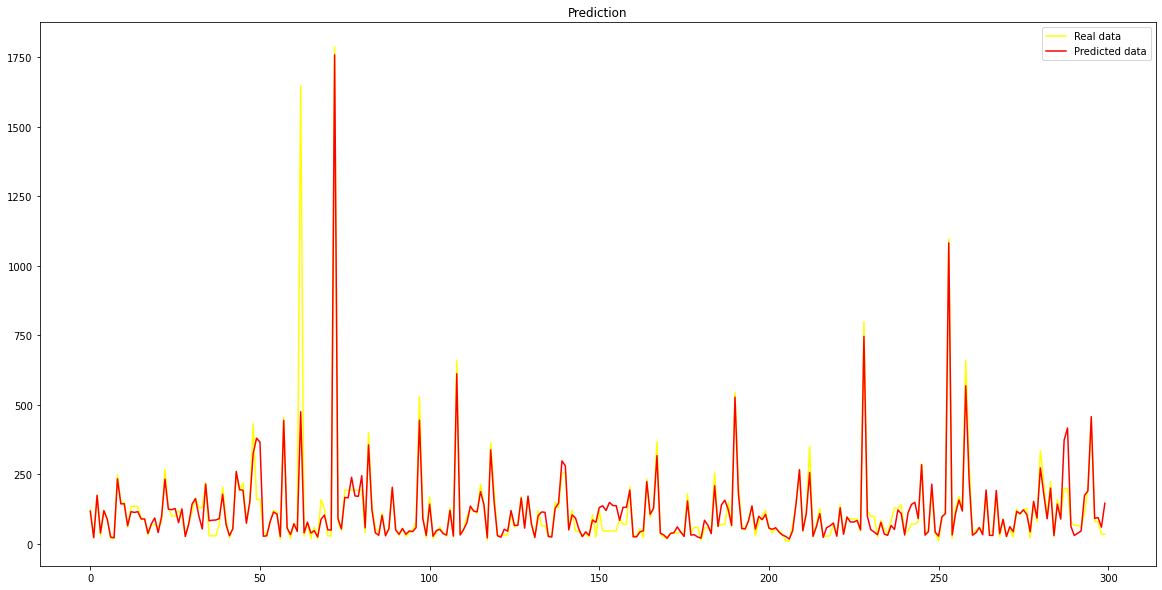

In [34]:
figure = plt.figure(figsize = (20,10))
plt.plot(y_test[300:600], color = 'yellow', label = 'Real data')
plt.plot(y_pred[300:600], color = 'red', label = 'Predicted data')
plt.title('Prediction')

plt.legend()
plt.savefig('prediction.png')
plt.show()

In [35]:
test = y_test - y_pred
test1= pd.DataFrame(test)
test1.describe()

,0
count,22282.000000
mean,-6.115879
std,91.026052
min,-2277.591553
25%,-12.029673
50%,0.153587
75%,11.701554
max,1281.418925


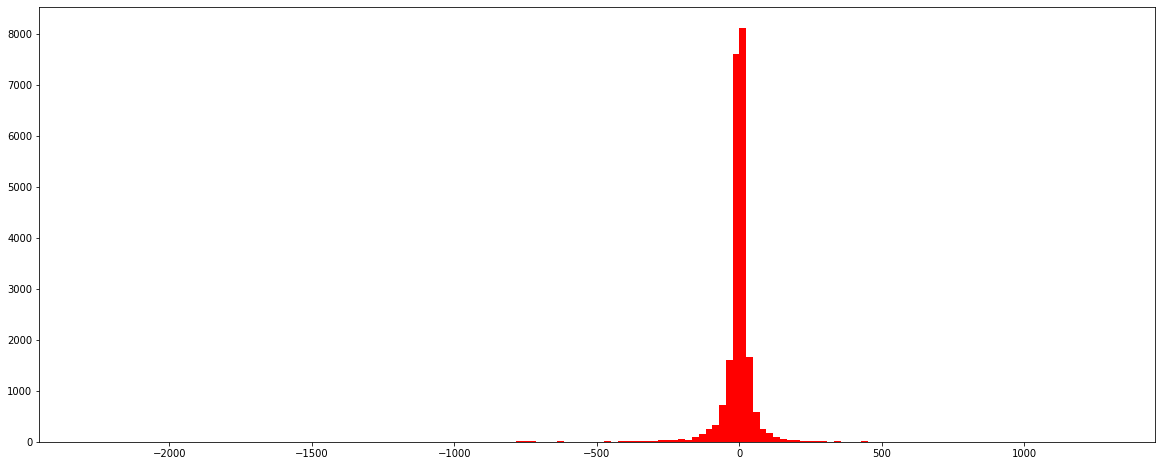

In [36]:
figure = plt.figure(figsize = (20,8))
plt.hist((y_test-y_pred), color = 'red', bins = 150)
plt.show()